# Event display for WbLS data
The 1-ton Water-based Liquid Scintillator (WbLS) detector is a R&D demonstrator for future neutrino or dark matter detectors currently operating at BNL. The WbLS recently developed enables separation between Cherenkov and scintillation signals, thus providing both directional reconstruction and enhanced low-energy efficiency.

![](https://drive.google.com/uc?export=view&id=11Ihqq1x2I5Yk2FFArB6ocmp9_9QyeDni)

This notebook will allow you to access the cosmics data you collected with the WbLS detector and display your events. Since the starting point are raw DAQ files, you will need to import some pre-existing Python modules to unpack them.



## Step 1: Setting up the environment
As always, we start by loading some Python packages that will be useful along the way.
Google Colab provides several pre-installed libraries that can be directly imported. Additional packages can be installed using `!pip install`.

In [31]:
# these packages are already available in Colab
# so we can import them directly
import os
import sys
import re
import glob
import statistics
import pandas as pd
import types
import numpy as np
from numpy import array, isscalar, uint16, uint32
from numpy import sqrt
from datetime import datetime
from scipy.stats import norm
from scipy.optimize import curve_fit
from lmfit import Model
from matplotlib import pyplot as plt

# these packages require to be installed
!pip install iminuit
from iminuit import Minuit
!pip install uproot
import uproot
!pip install numba
!pip install lmfit

print("uproot version:", uproot.__version__)

uproot version: 5.0.10


The next step is mounting a Google Drive access point, so that data files can be easily accessed. Moreover, this analysis requires a series of pre-written Python modules that will also be stored and accessed via Google Drive.

1.   Run the following cell and follow the instructions in the popup dialog to grant access to the Google Drive connected to your account.
2.   Go to [this Google Drive folder](https://drive.google.com/drive/folders/14SvWSV2c8bupNo5_yVhbXJ_kzsbUB6m_?usp=drive_link) and copy your data files (look for your group name) **and** the `modules` folder in your Google Drive.
4.   Fill the paths to your files/folders in the code. You can also copy the path by esploring the navigation menu on the left side of this page.

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# fill out the path to the 'modules' folder in your Google Drive
# e.g.: /content/drive/MyDrive/RENEW_DATA-Week_1/modules
MODULES_PATH = "/content/drive/MyDrive/RENEW_DATA-Week_1/modules"

# fill out the path to your collected data file in your Google Drive
# e.g.: /content/drive/MyDrive/RENEW_DATA-Week_1/sample_data_WbLS/phase2_wbls_1pct_muon_mid_x64_19mV_alpha_2023_0625_0.root
FILE_PATH = "/content/drive/MyDrive/RENEW_DATA-Week_1/sample_data_WbLS/phase2_wbls_1pct_muon_mid_x64_19mV_alpha_2023_0625_0.root"

The following cell uses the paths you provided to setup the pre-written Python modules, so that they can be referenced inside the notebook.
These pre-existing modules come from the [DROP](https://github.com/BNLIF/drop) reconstruction software, developed by those directly working on this R&D system at BNL.

In [34]:
# setting environment variables
SRC_DIR = MODULES_PATH+"/src"
YAML_DIR = MODULES_PATH+"/yaml"
LIB_DIR = MODULES_PATH+"/lib"
TOOL_DIR = MODULES_PATH+"/tools"
os.environ['LIB_DIR'] = LIB_DIR
os.environ['YAML_DIR'] = YAML_DIR
os.environ['SRC_DIR'] = SRC_DIR
os.environ['TOOL_DIR'] = TOOL_DIR
sys.path.append(SRC_DIR)

# setting up some additional path to calibration and configuration files
CALIB_FILE = MODULES_PATH+"/calib/bnl1t_spe_fit_results_230420T1832.csv"
CONFIG_PATH = MODULES_PATH+"/config_guang.yaml"

# building a libraries of utilities
os.system(MODULES_PATH+"/src/make_numba_lib.py")

# import functions from these python modules
from utilities import generate_colormap
from run_drop import RunDROP
from waveform import Waveform
from yaml_reader import YamlReader
from pulse_finder import PulseFinder
from yaml_reader import SAMPLE_TO_NS

## Step 2: Extracting data
The following cells contain functions to read-out data from the file. These function are organized in a *class*, called `WaveformExtractor`, which extracts both metadata and channel by channel information.

In particular, for every PMT readout channel, two quantities are extracted by analyzing the waveform:
*   The total collected charge in photoelectrons (`pe`), via `get_wfm_data()`.
*   The amplitude of the pulse in `mV`, via `get_wfm_data_mV()`.
Both are measures of the total amount of light collected by a PMT.





In [35]:
# extract datatime from a str. The datetime must follow the fixed format: YYmmddTHHMM
# this is necessary to read the metadata included in the file
def extract_datetime_from_str(s):

    match = re.search('\d{6}T\d{4}', s)
    if match:
        try:
            dt = datetime.strptime(match.group(), '%y%m%dT%H%M')
            return dt
        except ValueError:
            print('Fail finding the datetime string from path: %s' % s)

Let's now define the class that allows to quickly read out a file:

In [37]:
# this is the class that allows to read a file.
# it stores several parameters related to the detector configuration
# as well as running the function that extracts the data.

# Inputs:
#      raw_data_path (str): path to the raw root file
#      yaml_path (str): path to the configuration yaml file

class WaveformExtractor():
    def __init__(self, raw_data_path, yaml_path='yaml/config.yaml'):

        self.cfg = YamlReader(yaml_path) # load yaml config
        self.if_path = raw_data_path # get the file path

        # load metadata and calibration file
        # --> the are interal class functions (see below)
        self.load_run_info()
        self.load_pmt_info()

        # get daq tree via uproot
        f = uproot.open(raw_data_path)

        # get data from daq tree
        self.n_entries = f['daq'].num_entries

        # set configurations for waveform analysis
        self.wfm = Waveform(self.cfg)
        self.wfm.ch_names=self.ch_names # channel names
        self.wfm.ch_id = self.ch_id # channel ids
        self.wfm.n_boards = self.n_boards # number of boards
        self.wfm.spe_mean = self.spe_mean # single photoelectron response

        self.daq = f['daq'].arrays()
        self.entry_id = 0

    # ---------------
    # this function reads run info metadata
    # finds out datetime and which channels were on.
    def load_run_info(self):

        f = uproot.open(self.if_path)
        dt = extract_datetime_from_str(self.if_path)
        a = f['run_info'].arrays(['n_boards', 'active_ch_id', 'n_event_proc'], library='np')
        self.n_boards = uint16(a['n_boards'][0])
        self.n_event_proc = uint32(a['n_event_proc'][0])
        tmp = a['active_ch_id'][0]
        if isscalar(tmp): # if only 1 active channels, tmp is a scalar and sort will fail
            tmp = [tmp]
        self.ch_id = sorted(uint16(tmp))
        self.ch_names = ["adc_b%d_ch%d" % (i // 100, i % 100) for i in self.ch_id]
        self.ch_name_to_id_dict = dict(zip(self.ch_names, self.ch_id))

    # ---------------
    # the next two functions load up the correct calibration parameters
    # calibration is needed to be able to determine the number of photoelectrons
    # we calibrate the single photoelectron (spe) response of each PMT
    def load_pmt_info(self):

        self.spe_mean = {}
        fpath = CALIB_FILE # read the calibration file
        self._set_spe_result(fpath)

    def _set_spe_result(self, fpath):
        try:
            df = pd.read_csv(fpath)
            df.set_index('ch_name', inplace=True)
            self.spe_fit_results  = df # to be saved in root
            ch_names = df.index
            for ch in ch_names:
                self.spe_mean[ch] = float(df['spe_mean'][ch])
        except:
            sys.exit("your spe_fit_results_file cannot be loaded properly!")

    # ---------------
    # This function actually process one entry (event) of the file, given its index
    # it is called in a loop over the entire entries bt the following function
    def process_one(self, i):

        self.event_id = self.daq[i].event_id
        self.event_ttt = self.daq[i].event_ttt
        self.wfm.reset()
        self.wfm.set_raw_data(self.daq[i])
        self.wfm.find_saturation()
        self.wfm.subtract_flat_baseline()
        self.wfm.do_spe_normalization()
        self.wfm.define_trigger_position()
        self.wfm.correct_daisy_chain_trg_delay()
        self.wfm.sum_channels()
        self.wfm.define_time_axis()
        self.wfm.integrate_waveform()
        self.wfm.calc_roi_info()
        self.wfm.calc_aux_ch_info()

    def process_next(self):

        if self.entry_id<self.n_entries:
            i = self.entry_id
            self.process_one(i)
            self.entry_id+=1
            return True
        else:
            return False

    # ---------------
    # These last few functions are actually extracting data that we will be using
    # for the event display, in particular the total charge of the pulse (in pe)
    # this can be done for a specific input time interval and channel

    # ch_name: channel names identical to how it's defined in DROP.
    #    Options: sum_bot, sum_side, sum_row1,..., sum_row4, ..., sum_col1,..., sum_col4.
    #    Individual channels are accessible too. For example, adc_b1_ch3 is board 1 channel 3.
    def get_wfm_data(self, t_min=370, t_max=470, ch_name='sum_bot'):

        t = self.wfm.time_axis_ns
        mask = (t>=t_min) & (t<t_max)
        x_data=t[mask]
        y_data=self.wfm.amp_pe[ch_name][mask]
        return x_data, y_data

    def get_wfm_data_mv(self, t_min=370, t_max=470, ch_name='sum_bot'):

        t = self.wfm.time_axis_ns
        x_data=t
        y_data=self.wfm.amp_mV[ch_name]

        return x_data, y_data

    def get_aux_ch_mV(self, ch_name='adc_b1_ch0'):
        return self.wfm.aux_ch_area_mV[ch_name]

## Step 3: Preparing the display
Let's the prepare a function that displays data.

First, we define the `(x,y,z)` position of all PMTs in the detector. There are PMTs on the bottom and PMTs on the side (barrell) of the detector.

In [39]:
# bottom PMTs
locx_bot = [381, 381, 381, 381,
            190.5, 190.5, 190.5, 190.5, 190.5, 190.5, 190.5,
            0, 0, 0, 0, 0, 0, 0, 0,
           -190.5, -190.5, -190.5, -190.5, -190.5, -190.5, -190.5,
           -381, -381, -381, -381]
locy_bot = [-171.45, -57.15, 57.15, 171.45,
           -342.9, -228.6, -114.3, 0, 114.3, 228.6, 342.9,
           -400.05, -285.75, -171.45, -57.15,57.15, 171.45, 285.75, 400.05,
           -342.9, -228.6, -114.3, 0, 114.3, 228.6, 342.9,
           -171.45, -57.15, 57.15, 171.45]

# barrell PMTs
locx_side= [-532.955, -532.955,-532.955,-532.955,
               532.955,532.955,532.955,532.955,
               0,0,0,0,0,0,0,0,]
locy_side= [0,0,0,0,0,0,0,0,
               -532.955, -532.955,-532.955,-532.955,
               532.955,532.955,532.955,532.955]
locz_side= [-495.3, -336.55, 222.25, 393.7,
               -495.3, -336.55, 222.25, 393.7,
               -495.3, -336.55, 222.25, 393.7,
               -495.3, -336.55, 222.25, 393.7]

add description here, make 3D plot?

In [40]:
def display_charge(chg):
    dis_x=[]
    dis_y=[]
    area=[]
    area2=[]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.rcParams['figure.figsize'] = [15, 8]
    for i in range(len(chg)):
        if i < 30:
            area.append(chg[i]*50)
        elif i < 46:
            if i>29 and i<34:
                dis_x.append(0)
            if i>33 and i<38:
                dis_x.append(180)
            if i>37 and i<42:
                dis_x.append(90)
            if i>41 and i<46:
                dis_x.append(270)
            dis_y.append(locz_side[i-30])
            area2.append(chg[i-30]*50)

    ax1.scatter(locx_bot, locy_bot, s=area, c="Blue", alpha=1, label="Bottom plane")
    ax2.scatter(dis_x, dis_y, s=area2, c="Blue", alpha=1, label="Barrel plane")
    ax1.set_xlabel("X (mm)")
    ax1.set_ylabel("Y (mm)")
    ax2.set_xlabel("$\phi$ (deg.) with R = 533 mm")
    ax2.set_ylabel("Z (mm)")
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    plt.show()

## Step 4: Processing and plotting

add description

In [41]:
ch_string = ""
for i in range(15):
    ch_string += "adc_b1_ch{} ".format(i+1)
for i in range(15):
    ch_string += "adc_b2_ch{} ".format(i)
for i in range(16):
    ch_string += "adc_b3_ch{} ".format(i)
for i in range(12):
    ch_string += "adc_b4_ch{} ".format(i)

add description, add better arguments (ie. event entry)

In [45]:
class processor():
    def __init__(self):
        print("processor ready")

    def process_data(self, nevts, nruns, exa):

        tmin = 220
        tmax = 320
        tt = []
        tt_mv1 = []

        for ie in range(nruns):

            wf = WaveformExtractor(FILE_PATH, CONFIG_PATH)

            for ii in range(nevts):

                # process the first entry
                #print ('processing one event')
                wf.process_one(ii)
                event_id=wf.event_id
                event_ttt=wf.event_ttt
                #print('run_id:', run_id, "event_id:", event_id, "event_ttt:", event_ttt)

                evt_chg=[]
                chn_count = 0
                # get the data between t_min and t_max.
                for ich in ch_string.split():
                    if chn_count>45:
                        break
                    if "adc" in ich:
                        chn_count += 1
                        x_data, y_data = wf.get_wfm_data(t_min=0, t_max=2000, ch_name='{}'.format(ich))
                    else:
                        print ("can't do this channel")

                    yy_data = y_data.tolist()
                    aa = yy_data.index(np.max(yy_data))

                    tmin = x_data[aa] - 20
                    tmax = x_data[aa] + 40

                    if np.max(y_data) > -1e9:
                        if "adc" in ich:
                            x_data_mv, y_data_mv = wf.get_wfm_data(t_min=tmin, t_max=tmax, ch_name='{}'.format(ich))
                        else:
                            print ("can't do this channel")
                        summ_mv = 0
                        for idata in range(len(y_data_mv)):
                            summ_mv += y_data_mv[idata]*2
                        evt_chg.append(summ_mv)
                        if exa and chn_count<10:
                            plt.subplot(3,3,chn_count)
                            plt.plot(x_data_mv, y_data_mv, color='k', label='channel %s'%ich)
                    if exa:
                        plt.legend()

                if (wf.get_aux_ch_mV(ch_name='adc_b1_ch0') +wf.get_aux_ch_mV(ch_name='adc_b2_ch15')>300 ):
                    print ("this is a crossing muon.")
                else:
                    print ("this is not a crossing muon.")

                display_charge(evt_chg)

            del wf

        back_array = []
        return back_array


Explain how to run

processor ready
this is not a crossing muon.


/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


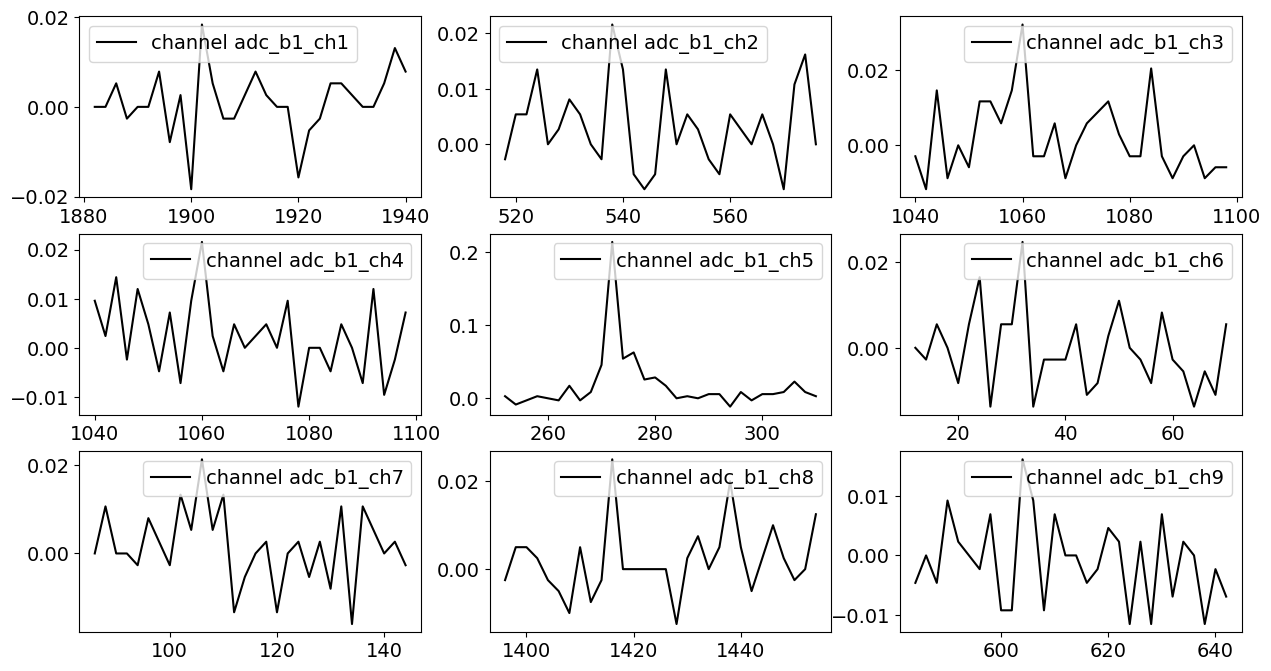

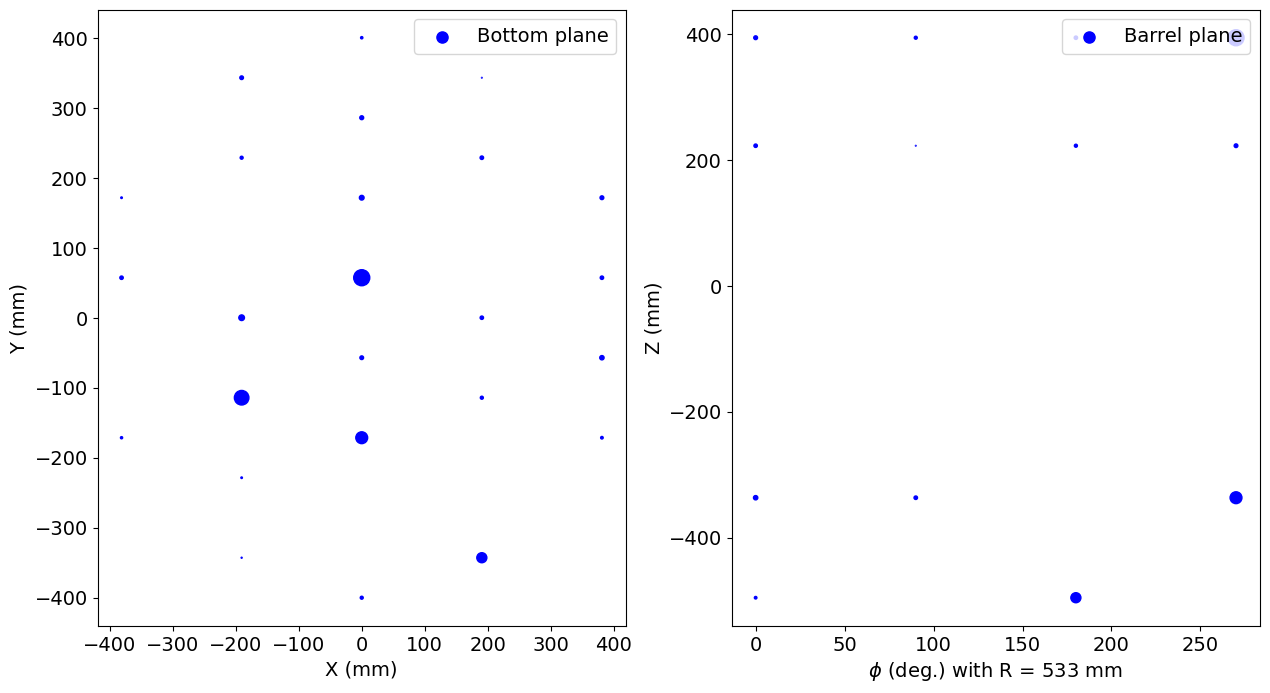

In [46]:
nevt =1
show_example=True

pr = processor()
# arguments: number of events, number of runs - should be 1, if want to show waveform examples
result = pr.process_data(nevt, 1, show_example)
